##### Installing necessary libraries

In [5]:
! pip install labelme albumentations

In [371]:
pip install --upgrade opencv-python

Note: you may need to restart the kernel to use updated packages.


##### Importing Necessary Libraries

In [2]:
import numpy as np, pandas as pd, random
import cv2 #opencv
import os
import time
import uuid #creates uniform unique identifiers
# import camera_detect
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import shutil as shu
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D

##### Data Collection and storing

-> IMAGES_PATH: This is the folder where we initally collect our data for the purpose of face detection

In [3]:
#specifying the folder where we collect our data - 
IMAGES_PATH = os.path.join(os.getcwd(),'data', 'images') 
number_images = 30
# node = uuid.getnode()

-> Capturing the images for training the model using OpenCV in batches of 30

In [19]:
capture = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret_val, frame = capture.read() # ret_val gives 0 or 1: img captured or not ; frame gives the captured frame
    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid4()) + '.png'}") # uuid4 used for security reasons - will not compromise network address
    cv2.imwrite(imgname, frame)
    # cv2.imshow('frame', frame)
    time.sleep(1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # code to allow us to break out of the loop when required
        break

capture.release()
cv2.destroyAllWindows

<function destroyAllWindows>

##### Data Labeling

In [9]:
! labelme #annotate the images with bounding boxes where faces are present

usage: labelme [-h] [--version] [--reset-config]
               [--logger-level {debug,info,warning,fatal,error}]
               [--output OUTPUT] [--config CONFIG] [--nodata] [--autosave]
               [--nosortlabels] [--flags FLAGS] [--labelflags LABEL_FLAGS]
               [--labels LABELS] [--validatelabel {exact}] [--keep-prev]
               [--epsilon EPSILON]
               [filename]
labelme: error: unrecognized arguments: the images with bounding boxes where faces are present


##### Limit GPU Memory growth - for GPU usage and to prevent OOM errors while training on a GPU

In [4]:
# to avoid OOM errors by setting GPU Memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

##### Load Image data into tensorflow pipeline

In [ ]:
images = tf.data.Dataset.list_files(IMAGES_PATH + '\\*.png', shuffle=False)

In [7]:
# function to convert the image to a tensor
def load_image(x):
    byte_img = tf.io.read_file(x) #returns a byte encoded image
    img = tf.io.decode_png(byte_img)
    return img

In [19]:
images = images.map(load_image)
images.as_numpy_iterator().next() #returns the full file path to the image

array([[[198, 182, 183],
        [197, 180, 181],
        [195, 179, 179],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[195, 181, 182],
        [195, 181, 183],
        [195, 181, 184],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[196, 182, 181],
        [197, 182, 181],
        [197, 181, 180],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[170, 159, 154],
        [169, 159, 154],
        [168, 159, 154],
        ...,
        [183, 179, 173],
        [182, 178, 172],
        [183, 179, 173]],

       [[168, 159, 154],
        [168, 159, 154],
        [167, 158, 153],
        ...,
        [183, 179, 176],
        [183, 178, 177],
        [183, 178, 177]],

       [[171, 160, 158],
        [170, 160, 157],
        [169, 160, 155],
        ...,
        [183, 179, 173],
        [183, 179, 173],
        [183, 179, 173]]

##### Visualizing the images (Raw files)

In [20]:
#batches the images
image_generators = images.batch(4).as_numpy_iterator()

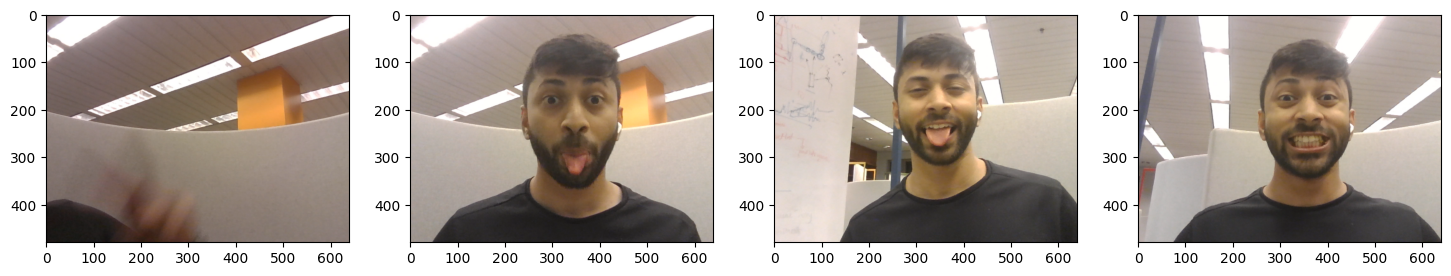

In [27]:
plot_images = image_generators.next() #used as a means for SGD

fig, ax = plt.subplots(ncols=4, figsize=(18,18))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

##### Data Splitting - Train, Test, Validation Splits of Unaugmented data

In [8]:
dir = ["train", "test", "val"] #list for iterating through the folders and setting the destination path for file movement

-> Custom script to count files in a directory (for a given file path - Needs to be specified as per use)

In [9]:
# path to the data folder: "C:\Users\Asus\OneDrive - Northeastern University\Personal projects\Computer_Vision\Face Detection\data\images"
# the destination folder are: "train", "test", and "val" in the "data" folder.

file_count = 0
#works for raw data only !!!
#counting the no. of files (images) in the folder:
for files in os.listdir(IMAGES_PATH):
    if os.path.isfile(os.path.join(IMAGES_PATH, files)):
        file_count+=1

# print(file_count)

# dividing the data into ratios: 70-15-15 for train-test-val
train_files = int(0.7 * file_count)
test_files = int(0.15 * file_count)
val_files = file_count - (train_files + test_files)

In [47]:
# moving the files to their respective train, test, and val folders
data_file_count = [train_files, test_files, val_files] #list of train, test, and val ratio for splitting 
for d, f in zip(dir, data_file_count):
    dest_path = os.path.join(os.getcwd(), "data", d, "images")
    count = 0
    while count < f:
        #Variable random_file stores the name of the random file chosen
        random_file=random.choice(os.listdir(IMAGES_PATH))
        # print("%d} %s"%(f+1,random_file))
        source_file = os.path.join(IMAGES_PATH,random_file)
        dest_file = dest_path
        #"shutil.move" function moves file from one directory to another
        shu.move(source_file,dest_file)
        count += 1
    

In [51]:
#automatic function to pick the respective labeled json files from the labels folder

for folder in dir:
    for file in os.listdir(os.path.join(os.getcwd(), "data", folder, "images")):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join(os.getcwd(), "data", "labels", filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, "labels", filename)
            os.replace(existing_filepath, new_filepath)

##### Applying Image and label Augmentations using albumentations for 1 image

In [10]:
#checking the size of the images
img = cv2.imread(os.path.join(os.getcwd(), 'data', "train", "images", "e58583ab-a622-4a11-8059-42d9b37facf9.png"))
img.shape

(480, 640, 3)

###### defining augmentation function

In [11]:
#implementing the image augmentation pipeline - develops images of aifferent kinds with the following augmentations
augmentor = alb.Compose([alb.RandomCrop(width= 450, height= 450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

###### Loading a test image and annotation with OpenCV and JSON

In [12]:
img = cv2.imread(os.path.join(os.getcwd(), 'data', "train", "images", "e58583ab-a622-4a11-8059-42d9b37facf9.png"))

with open(os.path.join(os.getcwd(), 'data', "train", "labels", "e58583ab-a622-4a11-8059-42d9b37facf9.json"), 'r') as f:
    label = json.load(f)

###### Extracting Coordinates and Rescaling to Match Image resolution

In [13]:
coords = [0,0,0,0]

# verifying to setting the coordinates as a list in th form of [x1,y1,x2,y2]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [14]:
label, coords

({'version': '5.2.1',
  'flags': {},
  'shapes': [{'label': 'face',
    'points': [[215.76719576719577, 31.26984126984128],
     [451.7460317460318, 371.48148148148147]],
    'group_id': None,
    'description': '',
    'shape_type': 'rectangle',
    'flags': {}}],
  'imagePath': '..\\images\\e58583ab-a622-4a11-8059-42d9b37facf9.png',
  'imageData': 'iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAIAAAC6s0uzAAEAAElEQVR4nOz9WZdk2XEdDO5tdtwjMrMmoKpQmEkCnMlPlFpa3f3X+6F/QD/3Wj18TX0iKYqiOGCoysxwv/eY7X4wO9c9sgAsioLEoeousBgZ4cMdzrFh27Zt/H/83/7vUpCQBMDMAdAACKCbAykF6wCNRpnRAAAwcZj7cBhSaTR3J3ka7kYzdxtm7uNEZ0KPp8dhA+5ptLMH5Q+PMIdR/b1AfXkdxLvHl3/zlT50d7P++48UNHW9zH2HkNd9f7oqkpCkiAQoITIFzAglpJRyjx1QpEhjysmUUooMAZGRGW4QEIkUIpNIp0yZiJAIDI4UBRMJmgQplZOcgOqLSCBBkOaiMhKAlICgBJjykNOGANbqSElK5szdSabczJz7vmdmiAkTIWAYnTBSgFI0plIQJDdDwm2QBlA5iQAp0igjY4YEACSTAgGlSZkiTaBAAVrLlSSAzJDSzCVse0aK9YEOEpAok5DSyc0NAYpOisxMGI2gk8qQUqwvBgCKRqs7kymApEhBQQAwwEjUt5MOSIqMJBCRGSlNc4EUoaRE0s1OZgPGVEROIAGksj7TaCYBCkQojW4cSgLmTkCpNNYDkRsBlQ1

In [15]:
#original format is the pascal_voc format and the transformed one is the 'albumentation' format
# -> refer albumentation documentation

resolution = [640, 480, 640, 480]
coords = list(np.divide(coords, resolution))
coords #results in a scaled 'albumentation' format

[0.3371362433862434,
 0.06514550264550266,
 0.7058531746031746,
 0.7739197530864197]

###### Running the above coords through the augmentor to test the results

In [16]:
augmented = augmentor(image= img, bboxes=[coords], class_labels=['face'])
augmented['image'], augmented['bboxes'], augmented['class_labels']

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [253, 255, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [253, 255, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [252, 253, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        ...,
 
        [[ 66,  62,  65],
         [ 66,  63,  66],
         [ 65,  62,  65],
         ...,
         [ 46,  44,  46],
         [ 49,  46,  48],
         [ 50,  47,  50]],
 
        [[ 67,  63,  66],
         [ 64,  61,  64],
         [ 65,  62,  65],
         ...,
         [ 47,  42,  45],
         [ 49,  46,  48],
         [ 48,  47,  50]],
 
        [[ 64,  61,  64],
         [ 63,  60,  62],
         [ 64,  61,  64],
         ...,
         [ 48,  43,  46],
  

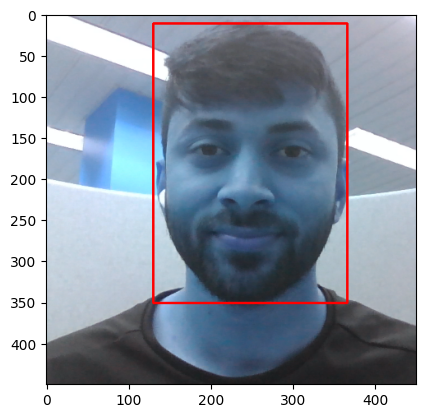

In [17]:
# visualing the above image - json to png
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

##### Building an Augmentation Pipeline for the complete data

In [18]:
for data_split in dir:
    for image in os.listdir(os.path.join(os.getcwd(), 'data', data_split, 'images')):
        img = cv2.imread(os.path.join(os.getcwd(), 'data', data_split, "images", image))

        coords = [0,0,0.000001,0.000001]
        label_path = os.path.join(os.getcwd(), 'data', data_split,'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]

            resolution = [640, 480, 640, 480]
            coords = list(np.divide(coords, resolution))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', 
                                         data_split, 
                                         'images', 
                                         f'{image.split(".")[0]}.{x}.jpg'), 
                                         augmented['image']) #saving the augmented image

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                with open(os.path.join('aug_data', data_split, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

##### Load Augmented Images in Tensorflow dataset

In [ ]:
dir = ["train", "test", "val"]

In [18]:
train_images = tf.data.Dataset
test_images = tf.data.Dataset
val_images = tf.data.Dataset
dataset_names = [train_images, test_images, val_images]

#map function trasnforms the dataset from one to another using a transformation function - returns a tf.data.Dataset 

for d, i in zip(dir, range(len(dataset_names))):
    dataset_names[i] = tf.data.Dataset.list_files(os.path.join(os.getcwd(), "aug_data", d, "images", "*.jpg"), shuffle=False)
    dataset_names[i] = dataset_names[i].map(load_image) 
    dataset_names[i] = dataset_names[i].map(lambda x: tf.image.resize(x, (150, 150))) #compressing the images for the input to the Deep NN
    dataset_names[i] = dataset_names[i].map(lambda x: x/255)

#assigning variables to the tensorflow datasets
train_images = dataset_names[0]
test_images = dataset_names[1]
val_images = dataset_names[2]

##### Prepare labels for our tensorflow dataset

###### Label Loading function

In [20]:
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class'], label['bbox']]

###### Load labels to the tensorflow dataset

In [21]:
#assigning the variables a types for initialization
train_labels = tf.data.Dataset
test_labels = tf.data.Dataset
val_labels = tf.data.Dataset
label_names = [train_labels, test_labels, val_labels]

for d, j in zip(dir, range(len(label_names))):
    label_names[j] = tf.data.Dataset.list_files(os.path.join(os.getcwd(), "aug_data", d, "labels", "*.json"), shuffle=False)
    label_names[j] = label_names[j].map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

train_labels = label_names[0]
test_labels = label_names[1]
val_labels = label_names[2]

In [24]:
#Look at the how the training labels are.. having a glimpse
train_labels.as_numpy_iterator().next()

(1, array([0.3904, 0.405 , 0.7983, 0.96  ], dtype=float16))

##### Create a combined images and labels dataset (This will be used for training the face dectection model)

###### Checking partition lengths

In [25]:
len(train_images), len(test_images), len(val_images), len(train_labels), len(test_labels), len(val_labels)

(3720, 780, 900, 3720, 780, 900)

###### Create the dataset

In [26]:
train_set = tf.data.Dataset.zip((train_images, train_labels))
train_set = train_set.shuffle(4300) #shuffle buffer > dataset size as there should be enough space to shuffle the dataset - works with datastructures..?
train_set = train_set.batch(8) 
train_set = train_set.prefetch(4)

test_set = tf.data.Dataset.zip((test_images, test_labels))
test_set = test_set.shuffle(1000)
test_set = test_set.batch(8)
test_set = test_set.prefetch(4)

val_set = tf.data.Dataset.zip((val_images, val_labels))
val_set = val_set.shuffle(1500)
val_set = val_set.batch(8)
val_set = val_set.prefetch(4)

In [27]:
train_set.as_numpy_iterator().next() #having a look at the files

(array([[[[0.5764706 , 0.5372549 , 0.49019608],
          [0.58431375, 0.5372549 , 0.49019608],
          [0.58431375, 0.5372549 , 0.49019608],
          ...,
          [0.12156863, 0.11764706, 0.10196079],
          [0.12156863, 0.11764706, 0.10196079],
          [0.1254902 , 0.12156863, 0.11372549]],
 
         [[0.5882353 , 0.5411765 , 0.49411765],
          [0.58431375, 0.53333336, 0.49803922],
          [0.5803922 , 0.5294118 , 0.49411765],
          ...,
          [0.1254902 , 0.12156863, 0.10588235],
          [0.12941177, 0.1254902 , 0.10980392],
          [0.12941177, 0.1254902 , 0.11764706]],
 
         [[0.5803922 , 0.53333336, 0.47843137],
          [0.5803922 , 0.53333336, 0.4862745 ],
          [0.5921569 , 0.5372549 , 0.49411765],
          ...,
          [0.13333334, 0.12941177, 0.11372549],
          [0.1254902 , 0.12156863, 0.10588235],
          [0.12941177, 0.1254902 , 0.11764706]],
 
         ...,
 
         [[0.6509804 , 0.5529412 , 0.5647059 ],
          [0.47058

In [28]:
train_set.as_numpy_iterator().next()[0].shape #just the image data batch

(8, 150, 150, 3)

###### Checking the Dataset - train, test, and validation

In [29]:
image = train_set.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


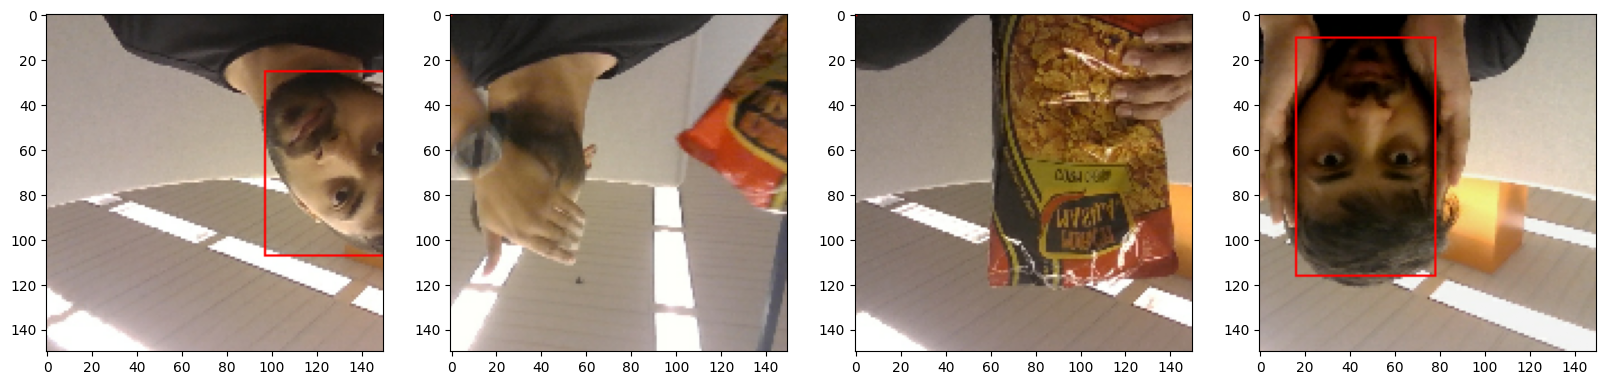

In [30]:
img_next = image.next() #processes the next batch in the dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = img_next[0][idx]
    sample_coords = img_next[1][1][idx]

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [150,150]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [150,150]).astype(int)),
                  (255,0,0), 1)
    
    ax[idx].imshow(sample_image)

##### Building the Deep Learning Model

###### Building the Neural Network for our face detection

In [31]:
#importing VGG model
from tensorflow.keras.applications import VGG16

In [32]:
# downloading VGG16 model
vgg = VGG16(include_top = False) #excludes the final layers of the VGG16 model that enable the object detection for which it was trained.

In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

-> Custom Deep Learning Model that has a classification and regression layer at the end for downstream task of Face detection.

In [34]:
def build_model():
    input_layer = Input(shape=(150,150,3)) #defining a custom input using the functional API to set our own input to the Neural Network

    vgg = VGG16(include_top= False)(input_layer)

    #Classification Model - to check if a face exists in the image or not
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    #Regression Model - to define the bounding box around the detected face
    f2 = GlobalMaxPooling2D()(vgg)
    reg1 = Dense(2048, activation='relu')(f2)
    reg2 = Dense(4, activation='sigmoid')(reg1)

    facetracker = Model(inputs=input_layer, outputs=[class2, reg2])
    return facetracker

###### Testing the neural network

In [35]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [36]:
X, y = train_set.as_numpy_iterator().next()
classes, coords = facetracker.predict(X)
classes, coords # done without training the network - as good as guesswork!!


1/1 [==============================] - 1s 1s/step


(array([[0.39017156],
        [0.3149234 ],
        [0.41228208],
        [0.25543314],
        [0.3133193 ],
        [0.2833408 ],
        [0.35758126],
        [0.48275167]], dtype=float32),
 array([[0.5979292 , 0.71032315, 0.55292064, 0.47199672],
        [0.5406985 , 0.709297  , 0.59743917, 0.53415984],
        [0.50419414, 0.6848442 , 0.526781  , 0.48346096],
        [0.49298713, 0.6836074 , 0.609503  , 0.45680407],
        [0.5105397 , 0.66893274, 0.5551088 , 0.48777995],
        [0.4832051 , 0.6597949 , 0.62956184, 0.46938136],
        [0.4606053 , 0.6292562 , 0.4899136 , 0.5451652 ],
        [0.41873878, 0.8072448 , 0.3439785 , 0.65296936]], dtype=float32))

##### Defining Loss Function, Optimizers and Hyperparameters

###### Hyperparameters

In [37]:
# decaying learning rate used so that the learning slows down with time and the model doesn't overfit and not blow out the ggradient
batches_per_epoch = len(train_set)
lr_decay = (1.0/0.75 - 1.0)/batches_per_epoch

In [38]:
# Optimizer
opti = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

###### Defining localization Loss Function for predicting the bouding boxes around the face

In [39]:
def localization_loss(y_true, y_hat):
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:, :2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_hat[:,3] - y_hat[:,1]
    w_pred = y_hat[:,2] - y_hat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_size + delta_coords

###### Defining the Classification Loss Function for first predicting whether a face exists in the image or not

In [ ]:
#assigning variables to the loss functions
classification_loss = tf.keras.losses.BinaryCrossentropy()
regression_loss = localization_loss

In [42]:
# Testing the Loss functions
classification_loss(y[0], classes), regression_loss(y[1], coords) # - It works, gives an output

(<tf.Tensor: shape=(), dtype=float32, numpy=0.8306052>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.352653>)

##### Building the Training pipeline for the Neural Network

In [43]:
class TrackFace(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, optimizer, classloss, regloss, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.classloss = classloss
        self.regloss = regloss

    def train_step(self, batch, **kwargs): #batch here is the sampled dataset
        X,y = batch #splitting features and labels into X and y

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.classloss(y[0], classes)
            batch_regloss = self.regloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_regloss + batch_classloss

            gradient = tape.gradient(total_loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))

        return {"total Loss": total_loss, "class loss": batch_classloss, "reg loss": batch_regloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training = False)

        batch_classloss = self.classloss(y[0], classes)
        batch_regloss = self.regloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_classloss + batch_regloss

        return {"total Loss": total_loss, "class loss": batch_classloss, "reg loss": batch_regloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [52]:
model = TrackFace(facetracker)

In [53]:
model.compile(opti, classification_loss, regression_loss)

##### Training the Model

In [54]:
#Creating a log directory to have logs of our training
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [55]:
hist = model.fit(train_set, epochs=5, validation_data=val_set, callbacks=[tensorboard_callback])
# hist = model.fit(train_set, epochs=50, validation_data=val_set, callbacks=[tensorboard_callback])

Epoch 1/5
465/465 [==============================] - 1738s 4s/step - total Loss: 0.3908 - class loss: 0.0863 - reg loss: 0.3045 - val_total Loss: 0.3617 - val_class loss: 0.1684 - val_reg loss: 0.1934
Epoch 2/5
465/465 [==============================] - 1518s 3s/step - total Loss: 0.1531 - class loss: 0.0303 - reg loss: 0.1228 - val_total Loss: 0.0739 - val_class loss: 0.0173 - val_reg loss: 0.0565
Epoch 3/5
465/465 [==============================] - 1587s 3s/step - total Loss: 0.1262 - class loss: 0.0297 - reg loss: 0.0965 - val_total Loss: 0.0494 - val_class loss: 0.0271 - val_reg loss: 0.0223
Epoch 4/5
465/465 [==============================] - 1443s 3s/step - total Loss: 0.0980 - class loss: 0.0201 - reg loss: 0.0779 - val_total Loss: 0.0165 - val_class loss: 2.9648e-04 - val_reg loss: 0.0162
Epoch 5/5
465/465 [==============================] - 1314s 3s/step - total Loss: 0.1139 - class loss: 0.0287 - reg loss: 0.0853 - val_total Loss: 0.3499 - val_class loss: 0.2051 - val_reg loss

##### Plotting Model Performance

In [56]:
hist.history

{'total Loss': [0.20160427689552307,
  0.05107007920742035,
  0.06251616030931473,
  0.009790703654289246,
  0.012134897522628307],
 'class loss': [0.0017724272329360247,
  0.0003560192126315087,
  0.006589488126337528,
  4.5487966417567804e-05,
  0.00016141438391059637],
 'reg loss': [0.19983184337615967,
  0.05071406066417694,
  0.055926673114299774,
  0.009745215997099876,
  0.011973483487963676],
 'val_total Loss': [0.36174309253692627,
  0.07386167347431183,
  0.04937934875488281,
  0.01650746539235115,
  0.3498837947845459],
 'val_class loss': [0.16836324334144592,
  0.01731772907078266,
  0.027104854583740234,
  0.0002964805462397635,
  0.20511484146118164],
 'val_reg loss': [0.19337984919548035,
  0.056543946266174316,
  0.022274496033787727,
  0.01621098443865776,
  0.14476896822452545]}

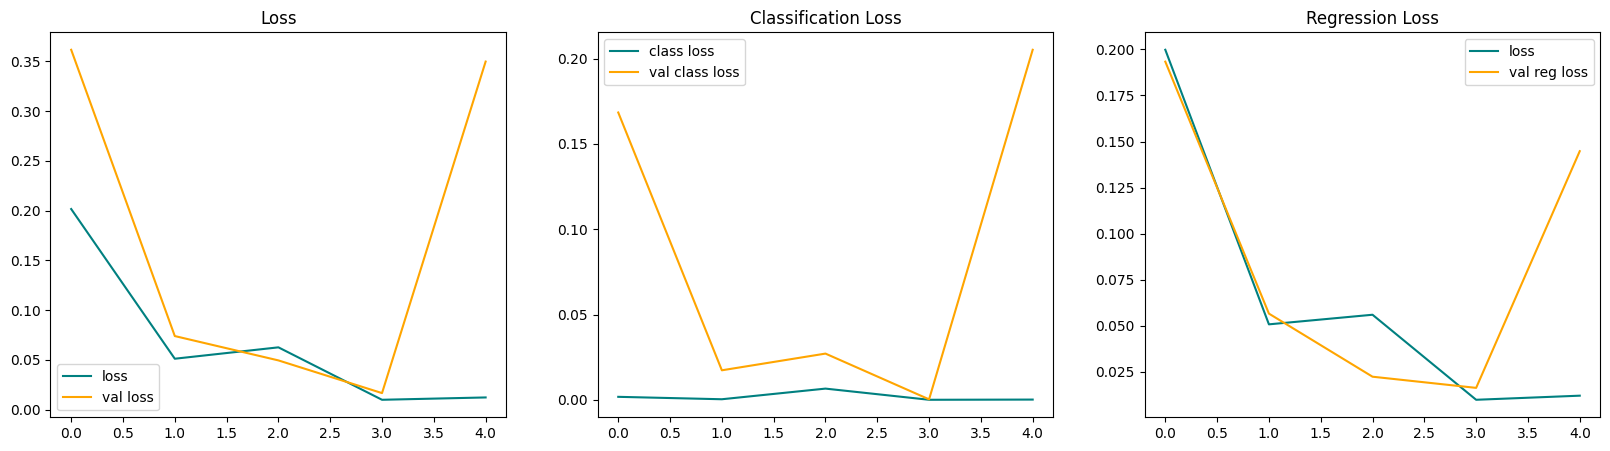

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total Loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total Loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['reg loss'], color='teal', label='loss')
ax[2].plot(hist.history['val_reg loss'], color='orange', label='val reg loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

##### Make Predictions on Test Set

In [59]:
test_data = test_set.as_numpy_iterator()

In [60]:
test_sample = test_data.next()
y_hat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 571ms/step


###### Visualizing the prediction image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


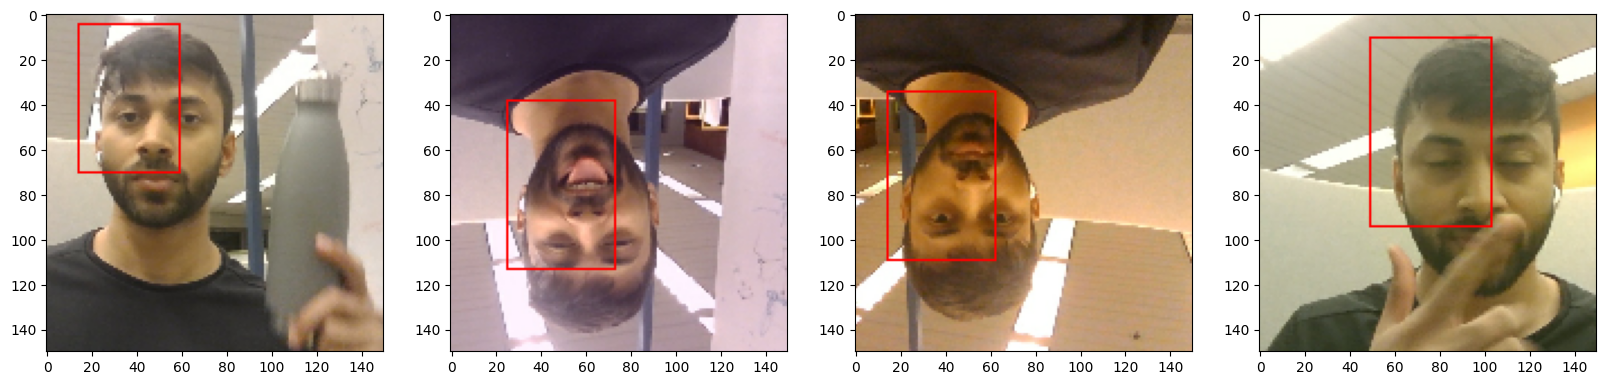

In [61]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = y_hat[1][idx]

    if y_hat[0][idx] > 0.9: #defining the threshold for classification..?
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255, 0, 0), 1)
        
    ax[idx].imshow(sample_image)

##### Saving the Model

In [ ]:
facetracker.save('facetracker.h5') #save sthe model checkpoint with the given name

In [5]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5') #loading the saved model for further usage

##### Real Time Face Detection

In [17]:
capture = cv2.VideoCapture(0)
while capture.isOpened():
    c, frame = capture.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (150, 150))

    y_hat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = y_hat[1][0]

    if y_hat[0]>0.5:
        #Controls the main rectangle for the face
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), (0,0,255), 3)
        
        #Controls the label on the rectangle
        # cv2.rectangle(frame,
        #               tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-30])),
        #               tuple(np.add(np.multiply(sample_coords[2:], [450,450]).astype(int), [-60,-300])),
        #               (255,0,0), 2)
        
        #Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                    cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 96ms/step


In [4]:
capture.release()
cv2.destroyAllWindows

<function destroyAllWindows>